In [25]:
import numpy as np
import matplotlib.pyplot as plt

## Data Exploration

In [26]:
class SignalProcessor:
    def __init__(self, signal_path: str, chunks: int = 1024):
        """
        Initialize SignalProcessor
        Parameters:
        - signal_file_path (str): Path to the raw signal file.
        - info_file_path (str): Path to the raw info file.
        """
        self.signal_file_path = signal_path
        self.chunks = chunks

        self.signal_data = self._load_signal_data()

    def _load_signal_data(self):
        """
        Load raw signal data from the specified file.
        Returns:
        - signal_data (numpy.ndarray): Loaded signal data reshaped into chunks of self.chunks.
        """
        with open(self.signal_file_path, 'rb') as signal_file:
            signal_data = np.fromfile(signal_file, dtype=np.uint8)
            signal_data = signal_data.reshape(-1, self.chunks)
        return signal_data
    
    def plot_signals(self, num_signals=50):
        """
        Plot a subset of signals.
        Parameters:
        - num_signals (int): Number of signals to visualize.
        """
        _, axs = plt.subplots(10, 5, figsize=(15, 30))
        axs = axs.flatten()
        for i in range(min(num_signals, len(self.signal_data))):
            axs[i].plot(self.signal_data[i])
            axs[i].set_title(f'Signal {i + 1}')
        plt.tight_layout()
        plt.show()

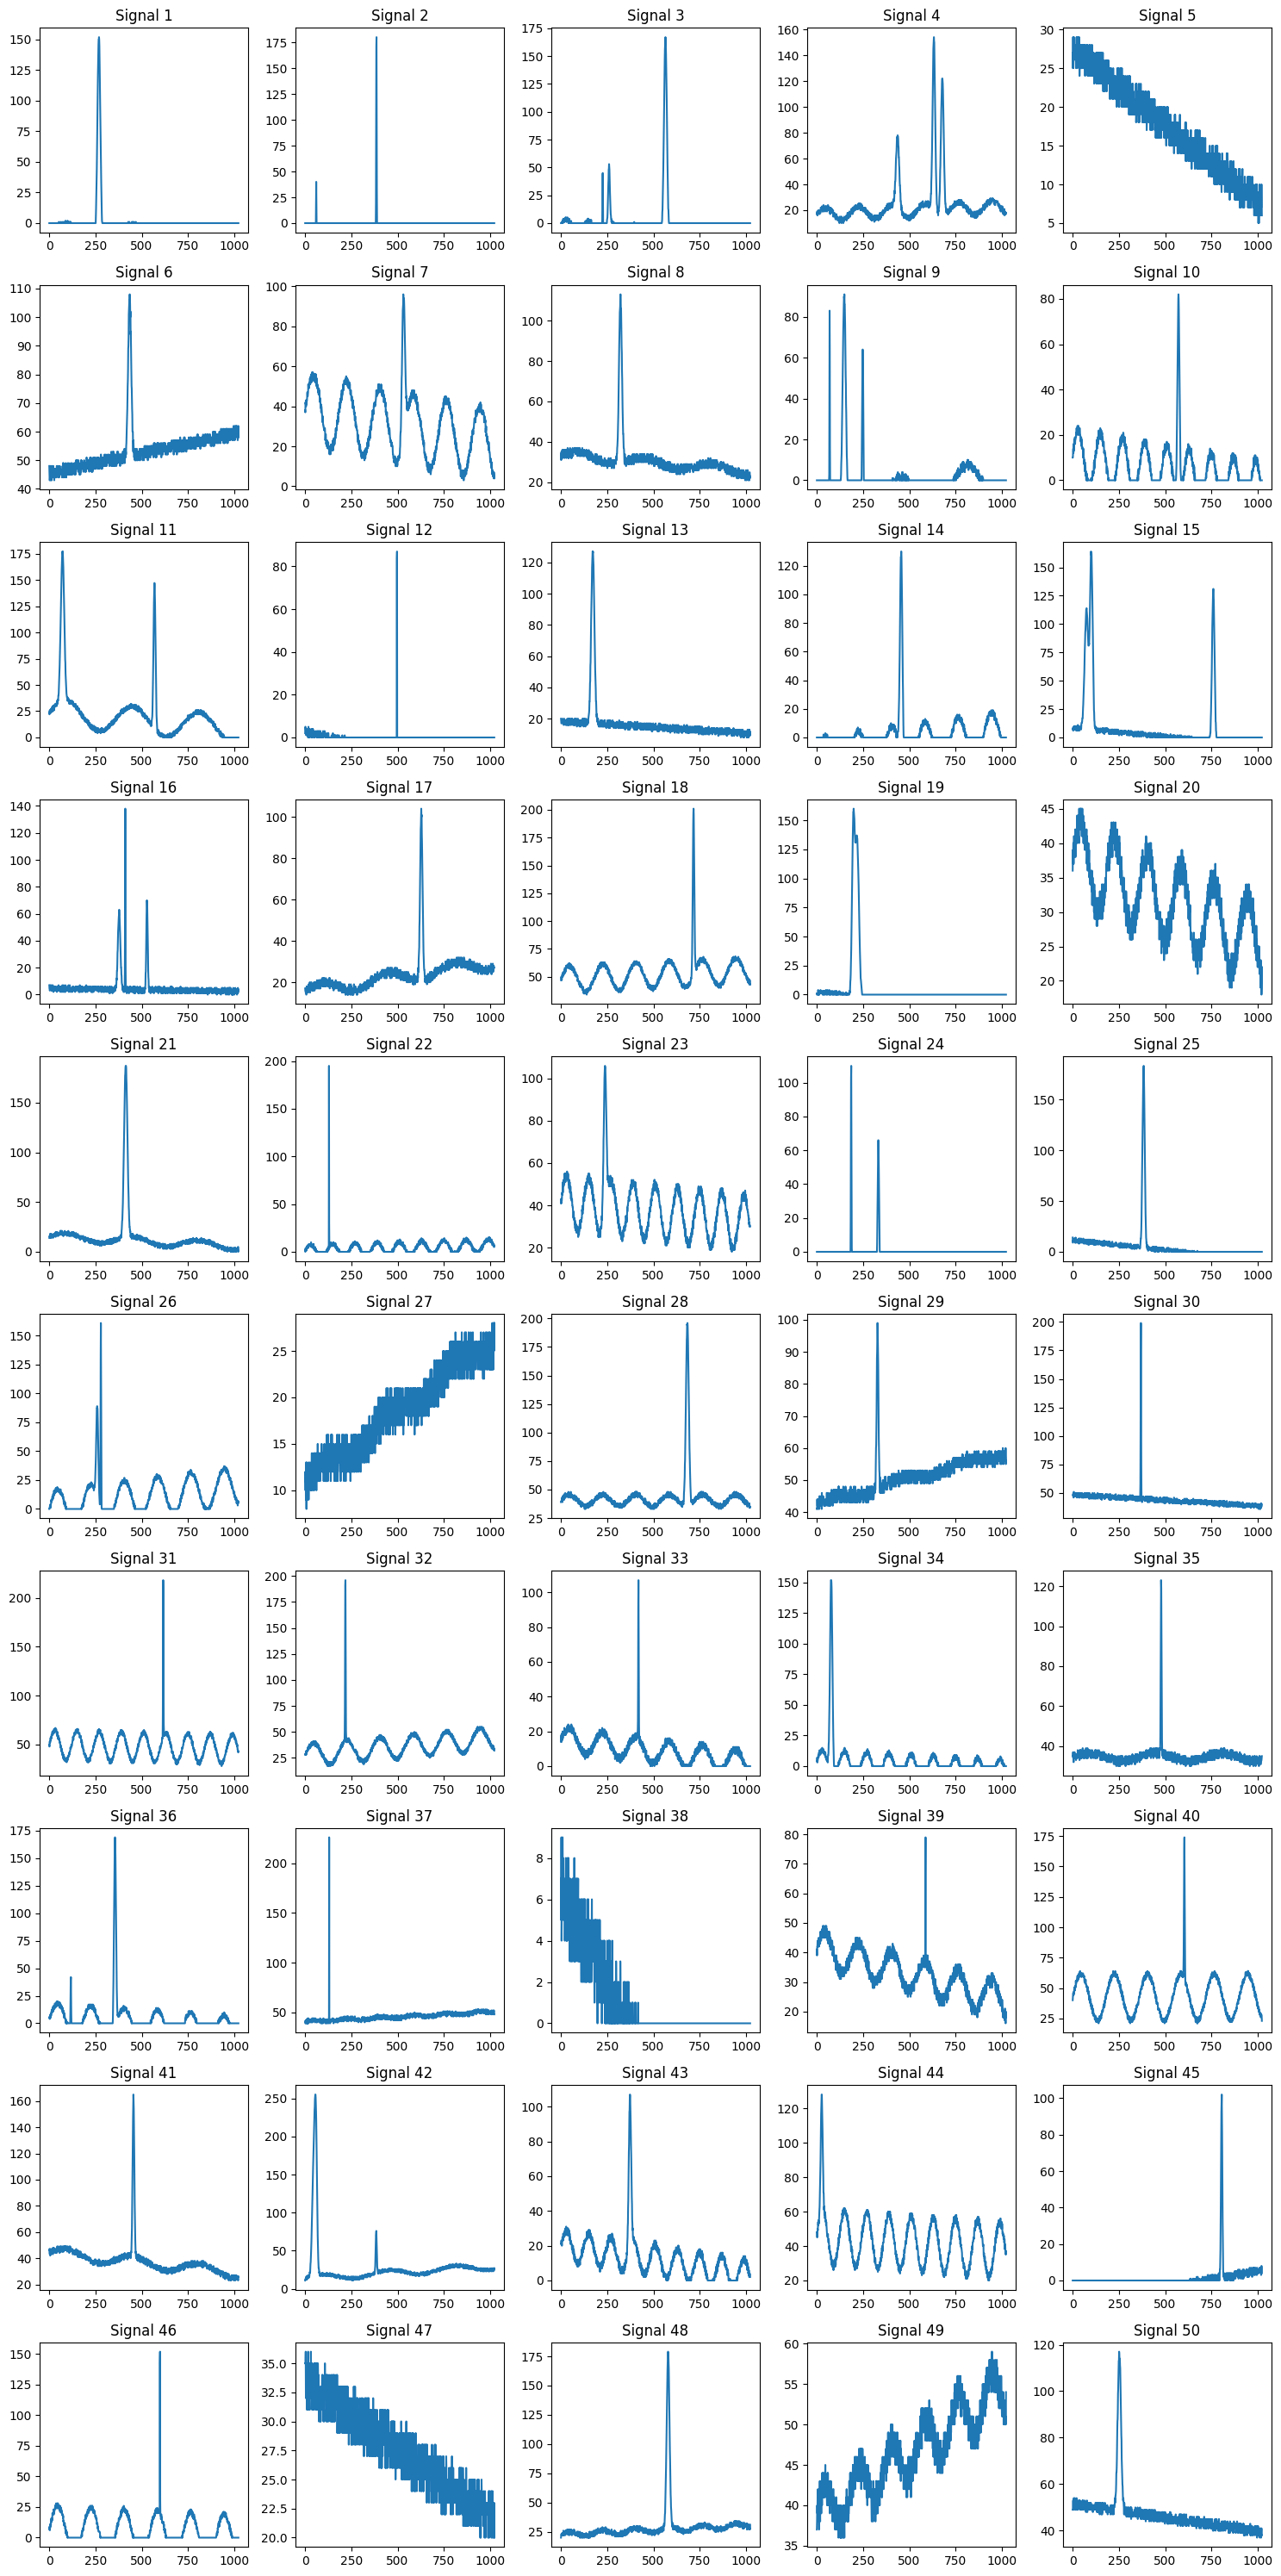

In [27]:
signal_processor = SignalProcessor("../data/signal.raw")
signal_processor.plot_signals()